# Models

The algorithms implemented in Sia use dynamical system models to predict how the state $x \in \mathbb{R}^n$ is expected to change (known as the dynamics equation).  Estimation problems also use a prediction of how the state is measured (known as the measurement equation).  Dynamical systems are assumed Markov, that is the current state $x_k$ is a function of the state at the previous time step $x_{k-1}$ and any external controls $u \in \mathbb{R}^m$.

In `sia`, there are two primary types of models that serve as base classes for other models.
- `sia.DynamicsModel`.  This model predicts $p(x_k | x_{k-1}, u_k)$, i.e. the statistical propogation from state $x_{k-1}$ to $x_k$ given a control $u_k$.  There are two flavors of this dynamics model:
  - *Discrete time.*  In this case the user provides the equation above which makes implicit assumptions about the time step.
  - *Continuous time.*  In this case the user provides an equation $p(\dot{x} | x, u)$ and a timestep $\Delta t$.  The state propogation is then found via Runge Kutta integration.
- `sia.Measurementmodel`.  This model predicts $p(y | x)$, i.e. the statistical measurement $y$ from state $x$.

There are additional linearizable models `sia.LinearizableDynamics` and `sia.LinearizableMeasurement` that provide additional access to the Jacobians needed for gradient-based algorithms.  `sia` provides several implementations outlined below.

In [1]:
# Import the libSIA python bindings and numpy
import pysia as sia
import numpy as np

# Import plotting helpers
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")

# Set the generator instance seed for repeatability
generator = sia.Generator.instance()
generator.seed(1)

## Linear Gaussian Systems
Linear Gaussian systems make linear assumptions about the dynamics and measurement equations and assume that noise is added linearly.

### Discrete time
`sia.LinearGaussianDynamics` implements
$$x_k = F x_{k-1} + G u_k + w_k,\quad w_k \sim \mathcal{N}(0, Q)$$
`sia.LinearGaussianMeasurement` implements
$$y_k = H x_k + v_k,\quad v_k \sim \mathcal{N}(0, R)$$

### Continuous Time
`sia.LinearGaussianDynamicsCT` implements
$$\dot{x} = A x + B u + w,\quad w \sim \mathcal{N}(0, Q_{psd})$$
`sia.LinearGaussianMeasurementCT` implements
$$y = H x + v,\quad v \sim \mathcal{N}(0, R_{psd})$$

Note that when converting between discrete time and continuous time, the noise matrices represent different values.  In discrete time, $Q,R$ represent covariance matrices which have an implicit time step, while $Q_{psd},R_{psd}$ matrices represent power spectral densities (PSD) which are time invariant.  `sia` uses first-order Taylor series expansions to convert between covariance and power spectral density.
$$Q = Q_{psd} \Delta t$$
$$R = \frac{R_{psd}}{\Delta t}$$


Below is an example that simulates multiple trajectories for a discrete time Linear/Gaussian system.

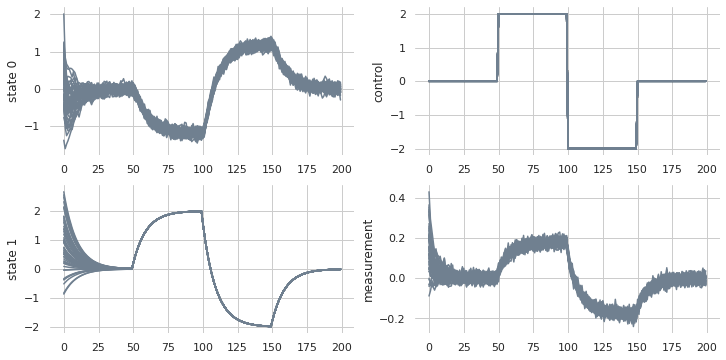

In [2]:
# Create a linear Gaussian system
linear_dynamics = sia.LinearGaussianDynamics(
    F=np.array([[0.5, -0.3], [0, 0.9]]),
    G=np.array([[0], [0.1]]),
    Q=np.diag([5e-3, 1e-6])
)
linear_measurement = sia.LinearGaussianMeasurement(
    H=np.array([[0.1, 0.15]]),
    R=np.array([[2e-4]])
)

# Create a positive/negative step command
u = np.zeros((1, 200))
u[0, 50:] = 2
u[0, 100:] = -2
u[0, 150:] = 0

# Create an initial state distribution
initial_state = sia.Gaussian(np.ones(2), np.identity(2))
x = initial_state.samples(num_samples=50)

# Simulate the system with noise for the input vector
trajectories = sia.simulate(linear_dynamics, linear_measurement, x, u, sample=True)

# Plot the trajectories from the simulation
f, ax = plt.subplots(nrows=2, ncols=2, figsize=(12, 6))
sns.despine(f, left=True, bottom=True)
for traj in trajectories.data():
    ax[0, 0].plot(traj.states[0, :], color="slategray")
    ax[0, 0].set_ylabel("state 0")
    
    ax[1, 0].plot(traj.states[1, :], color="slategray")
    ax[1, 0].set_ylabel("state 1")
        
    ax[0, 1].plot(traj.controls[0, :], color="slategray")
    ax[0, 1].set_ylabel("control")
        
    ax[1, 1].plot(traj.measurements[0, :], color="slategray")
    ax[1, 1].set_ylabel("measurement")
plt.show()

## Nonlinear Gaussian Systems
Nonlinear Gaussian systems relax the linear assumptions about the dynamics and measurement equations, but still assume that noise is added linearly.

### Discrete time
`sia.NonlinearGaussianDynamics` implements
$$x_k = f(x_{k-1}, u_k) + w,\quad w \sim \mathcal{N}(0, Q)$$
`sia.NonlinearGaussianMeasurement` implements
$$y = h(x) + v,\quad v \sim \mathcal{N}(0, R)$$

### Continuous Time
`sia.NonlinearGaussianDynamicsCT` implements
$$\dot{x} = f(x, u) + C w,\quad w \sim \mathcal{N}(0, Q_{psd})$$
`sia.NonlinearGaussianMeasurementCT` implements
$$y = h(x) + v,\quad v \sim \mathcal{N}(0, R_{psd})$$

Conversion between covariance and power spectral density (PSD) from linear systems applies to the nonlinear Gaussian case.  Below is an example that simulates multiple trajectories for a continuous time Nonlinear Gaussian system.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys


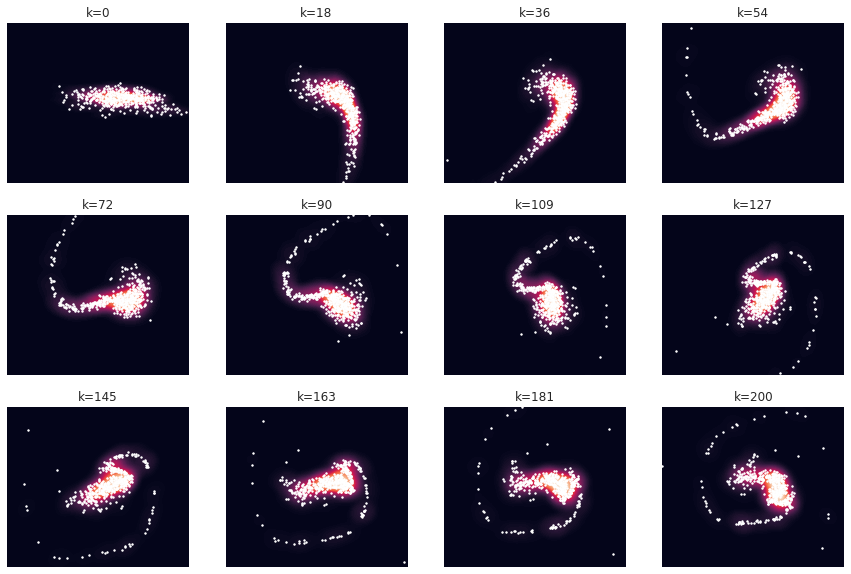

In [3]:
# Sample rate (s)
dt = 0.01

# Initialize dynamics for the Duffing oscillator
dynamics = lambda x, u: np.array([
    x[1],
    -0.02 * x[1] - x[0] - 5 * x[0]**3 + 8 * u
])

nonlinear_dynamics = sia.NonlinearGaussianDynamicsCT(
    dynamics=dynamics,
    Qpsd=np.diag([1e-6, 1e-2]),
    dt=dt
)

# Observe the velocity state
measurement = lambda x: np.array([x[1]])

nonlinear_measurement = sia.NonlinearGaussianMeasurementCT(
    measurement=measurement,
    Rpsd=np.array([[1e-4]]),
    dt=dt
)

# Create a sinusoidal control
t = np.arange(0, 2+dt, dt)
u = np.cos(0.5 * t)
u = np.reshape(u, (1, len(t)))

# Create an initial state distribution
initial_state = sia.Gaussian(np.ones(2), np.identity(2))
x = initial_state.samples(num_samples=500)

# Simulate the system with noise for the input vector
trajectories = sia.simulate(nonlinear_dynamics, nonlinear_measurement, x, u, sample=True)

# Plot the states at different snapshots in time
indices = np.linspace(0, len(t)-1, 12).astype(int)
f, ax = plt.subplots(nrows=3, ncols=4, figsize=(15, 10))
xx, yy = np.meshgrid(np.linspace(-4, 4, 51), np.linspace(-15, 15, 51))
ax = ax.flat
sns.despine(f, left=True, bottom=True)
for i in range(len(indices)):
    # Retrieve the samples at snapshot index
    k = indices[i]
    samples = trajectories.states(k)
        
    # Create a kernel density from the samples for the trajectory
    dist = sia.KernelDensity(samples, np.ones(trajectories.size()),
                             type=sia.Kernel.EPANECHNIKOV, bandwidth_scaling=2)
    prob = np.exp(sia.logProb2d(dist, xx.flatten(), yy.flatten()))
    ax[i].contourf(xx, yy, np.reshape(prob, xx.shape), levels=100)
    ax[i].scatter(samples[0, :], samples[1, :], s=2, color="white")
    ax[i].set_xlim([-4, 4])
    ax[i].set_ylim([-15, 15])
    ax[i].axis("off")
    ax[i].set_title("k={}".format(k))
plt.show()